##  Predicting Heart Disease

The [World Health Organization (WHO)](https://www.who.int/health-topics/cardiovascular-diseases) estimates that 17.9 million people die from cardiovascular diseases (CVDs) every year. 

There are multiple risk factors that could contribute to CVD in an individual, such as unhealthy diet, lack of physical activity, or mental illness. Identifying these risk factors early on could help prevent many premature deaths.

Let's say we are working for an R&D company that focuses on providing healthcare solutions. The company has collected anonymized data from multiple hospitals on several patients. The dataset includes relevant information for each patient, such as their personal information and some medical data, including whether or not they have had heart disease before.

We are tasked with using the dataset to accurately predict the likelihood of a new patient having heart disease in the future. The dataset has the following features:

- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
-` Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
-` RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
%matplotlib inline

In [2]:
heart_df = pd.read_csv('../Datasets/heart_disease_prediction.csv')
heart_df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
heart_df.shape

(918, 12)

##  EDA: Descriptive Statistics

Before we jump into building a model, let's conduct exploratory data analysis on the dataset.

We will start by exploring and analyzing the numerical columns.

Given the list of features and looking at some of the rows from the dataset, we see that we have both categorical and numerical features.

In [4]:
heart_df.dtypes

Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

The categorical columns will be dtype object for this dataset. We need to note that a couple of columns -- `FastingBS` and `HeartDisease` -- have the dtype int64, but are also categorical variables, since they only take the values 0 and 1.


The dataset seems to contain both numerical and categorical features. Let's look at the datatype for each column.

In [5]:
heart_df.dtypes.value_counts()

int64      6
object     5
float64    1
Name: count, dtype: int64

`7` features in total are numerical while `5` are categorical. However, two of the numerical features, `FastingBS` and `HeartDisease` are categorical as well.

We will focus on the numerical variables first.

In [6]:
heart_df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


From the table above, we can observe that:

- The average age of patients is ~`53` years.
- The median for `Cholesterol` is higher than its mean by roughly 25 mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.
- There don't seem to be any missing values in these columns. But we will have to confirm it across the entire dataset as well.

`RestingBP` can't be `0`. And, as per the [American Heart Association](), serum cholesterol is a composite of different measurements. So, it is unlikely that `Cholesterol` would be 0 as well. We will have to clean both of these up later.

Next, we will look at the categorical variables. It would also be beneficial to look at how the target feature, `HeartDisease`, is related to those categories. Before that, let's quickly check if there are any missing values in the dataset or not.

In [7]:
# check for missing values
heart_df.isna().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values in this dataset!

## EDA: Categorical Data

We identified that most of the categorical columns are all of dtype `object`.

In [8]:
heart_df.describe(include='object')

,Sex,ChestPainType,RestingECG,ExerciseAngina,ST_Slope
count,918,918,918,918,918
unique,2,4,3,2,3
top,M,ASY,Normal,N,Flat
freq,725,496,552,547,460


We can confirm that those columns are indeed categorical given the number of unique values in each of them. But, we can't gather much else. Also, `FastingBS` and `HeartDisease` are categorical as well since they only contain binary values. We can confirm that quickly as well.

In [9]:
heart_df['FastingBS'].unique(), heart_df['HeartDisease'].unique()

(array([0, 1], dtype=int64), array([0, 1], dtype=int64))

Based on the descriptive statistics, here are some of the observations that we can make:

- The average age of patients is ~`53` years.
- The median for `Cholesterol` is higher than its mean by roughly `25` mm/dl, indicating that it could be a left-skewed distribution with a possibility of outliers skewing the distribution.
- `RestingBP` and `Cholesterol` have a minimum value of zero.
- There don't seem to be any missing values in these columns.

A couple of observations stand out. RestingBP is the resting blood pressure, and it's unlikely to be zero. But what about `Cholesterol`?

Low cholesterol certainly sounds like a good thing, but can it be zero?

This is where domain expertise can help us. Since we might not be suited to answer the question, we could reach out to a subject matter expert or research it on our own.

As per the dataset description, Cholesterol contains the serum cholesterol values. And per the [American Heart Association](https://www.heart.org/en/health-topics/cholesterol/about-cholesterol/what-your-cholesterol-levels-mean), serum cholesterol:

is a composite of different measurements. Your total blood cholesterol is calculated by adding your HDL and LDL cholesterol levels, plus 20% of your triglyceride level.

The above information is enough to let us know that a 0 value for serum cholesterol is unlikely.


Let's start looking at the categories in more detail.

Our observations so far were only for a subset of the columns. Additionally, we don't know how the dataset is distributed in relation to our target variable -- `HeartDisease`. For example, how many patients had a resting ECG categorized as ST? How many female patients had heart disease?

We'll explore the categorical features next, but we'll rely on creating visualizations to understand how the data is distributed.

In [10]:
cat_cols = list(heart_df.select_dtypes(include='O').columns) + ['HeartDisease', 'FastingBS']
cat_cols

['Sex',
 'ChestPainType',
 'RestingECG',
 'ExerciseAngina',
 'ST_Slope',
 'HeartDisease',
 'FastingBS']

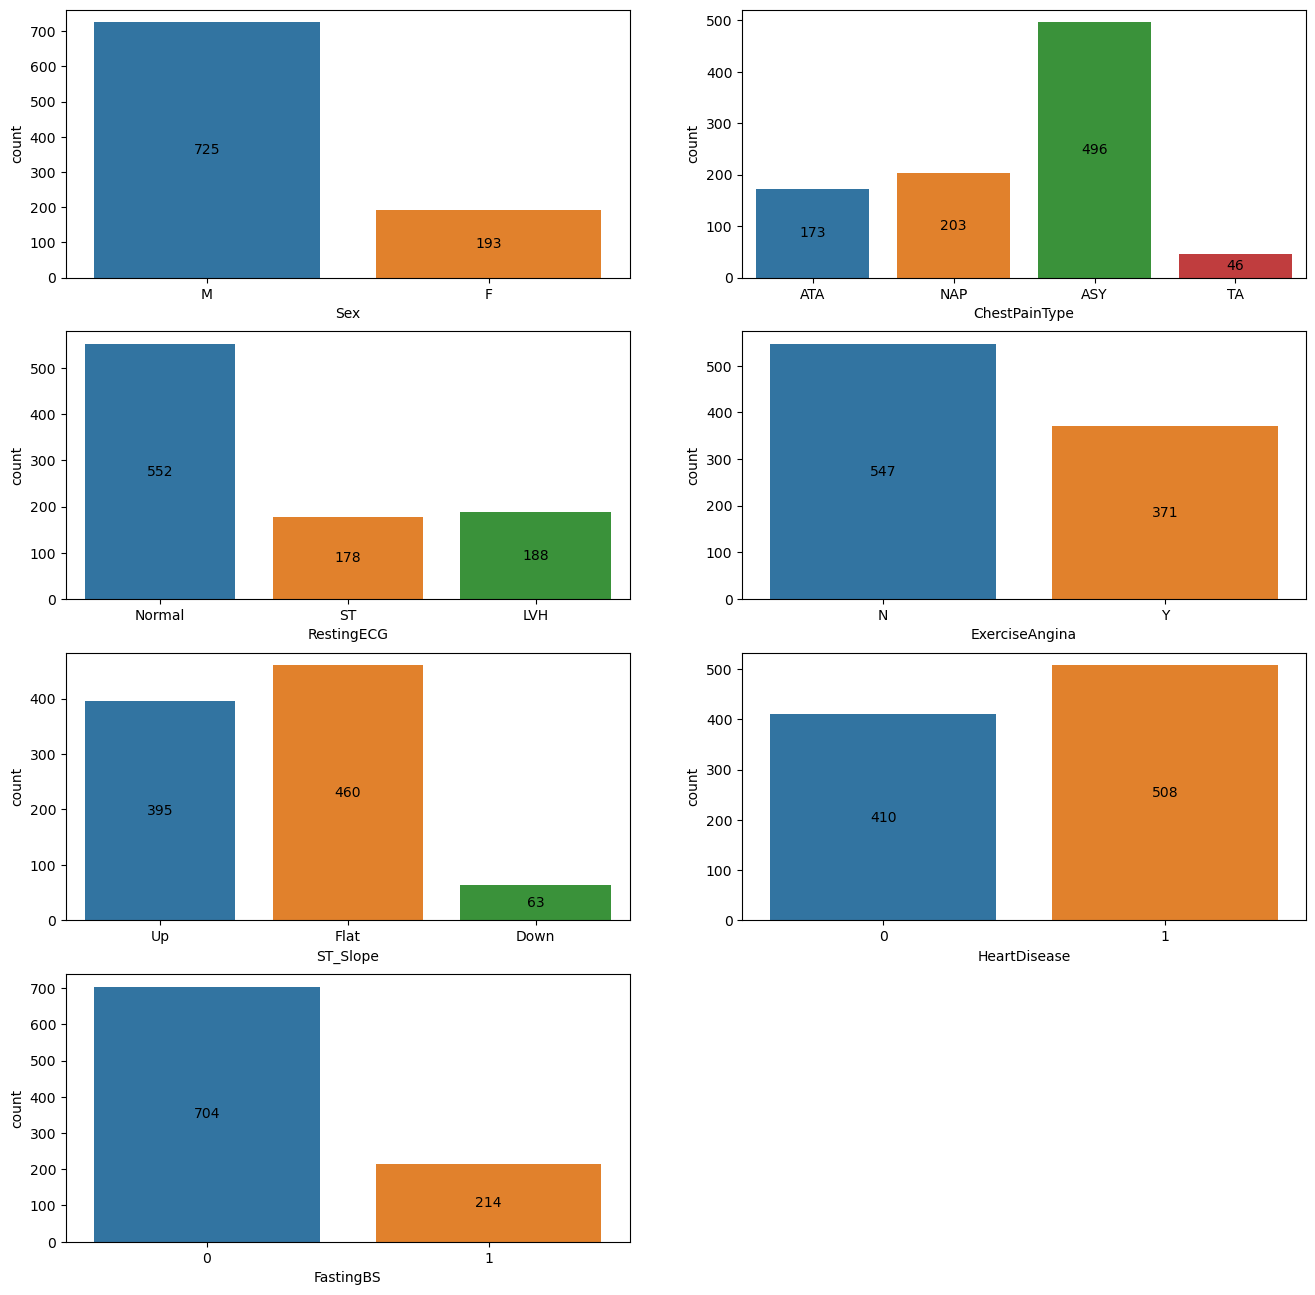

In [11]:
fig = plt.figure(figsize=(16, 16))

for i, col in enumerate(cat_cols):
    ax = plt.subplot(4, 2, i+1)
    sns.countplot(x=heart_df[col], ax=ax, hue=heart_df[col], legend=False)
    # add data labels to each bar
    for container in ax.containers:
        ax.bar_label(container, label_type="center")

- The dataset is highly skewed towards male patients. There are `725` male patients and `193` female patients. This could potentially induce a bias in our model.
- `496` patients had ASY (asymptotic) chest pain type.
- `552` patients had a normal restin ECG.
- `704` patients had blood sugar lower than `120` mg/dl

Grouping these by `HeartDisease` will give us a better idea about the data distribution.

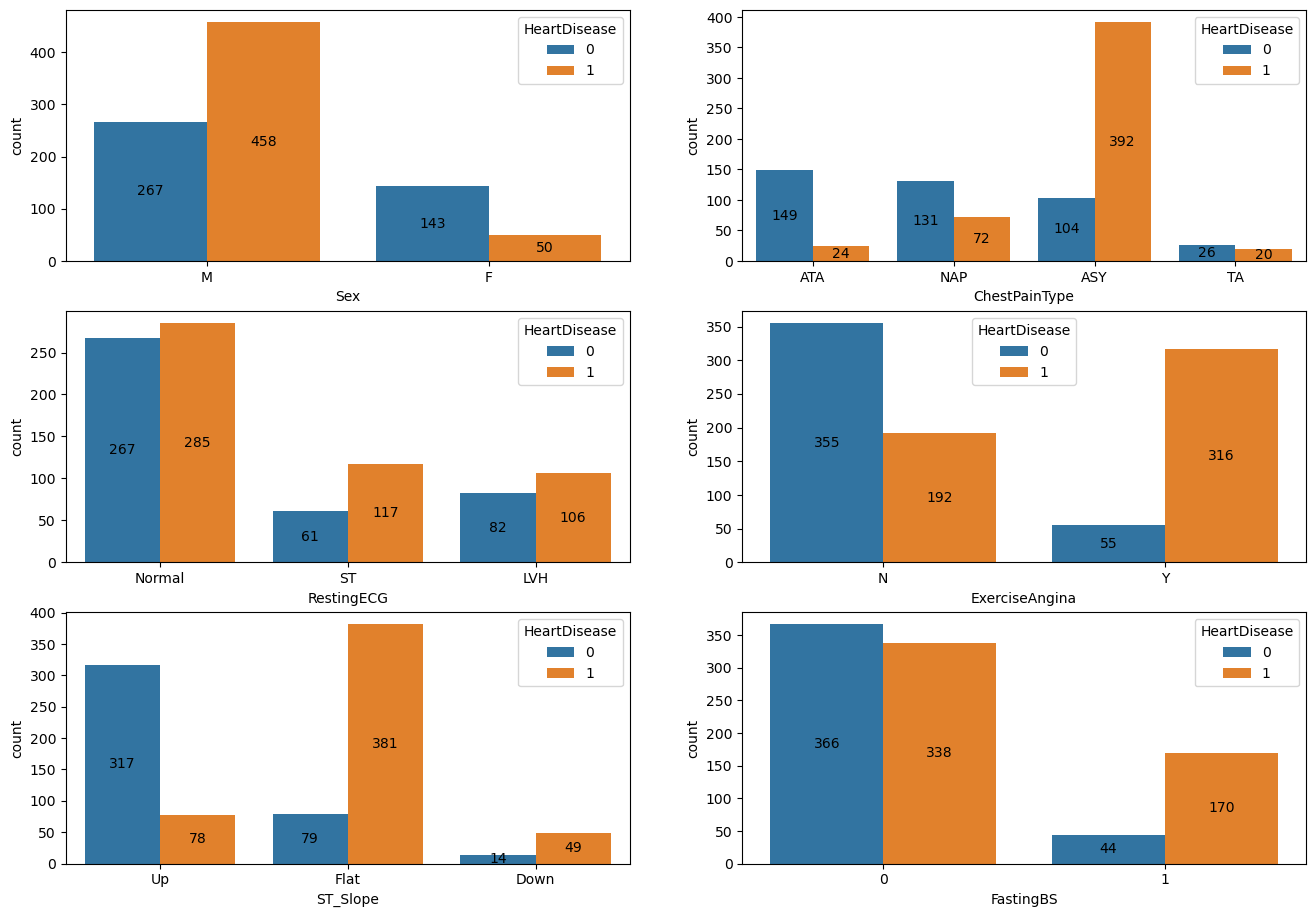

In [12]:
cat_cols = list(heart_df.select_dtypes(include='O').columns) + ['FastingBS']
fig = plt.figure(figsize=(16, 15))

for i, col in enumerate(cat_cols):
    ax = plt.subplot(4, 2, i+1)
    # group by HeartDisease
    sns.countplot(data=heart_df, x=col, hue='HeartDisease', ax=ax)
    # add data label
    for container in ax.containers:
        ax.bar_label(container, label_type='center')

- We can further notice how skewed the dataset is towards male patients. Only `50` female patients in the dataset have been diagnosed with heart disease.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (ASY) chest pain. While chest pain could be a relevant feature for our model, asymptomatic implies that those patients who had a heart disease did not have chest pain as a symptom.
- A high number (`170`) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not diagnosed as such.
- Out of all patients who had an exercise-induced angina, `316` were diagnosed with a heart disease.
- Out of all patients with a flat ST slope, `381` were diagnosed with a heart disease.

Looking at the data distribution from the above plots, we can start to identify some features that could be relevant to us. We will clean up the dataset a bit first before narrowing down on our features.

In [13]:
# What is the median age of patients who were diagnosed with heart disease?

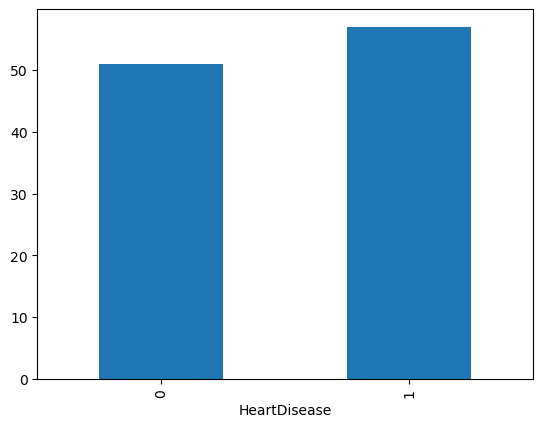

In [14]:
heart_df.groupby('HeartDisease')['Age'].median().plot.bar()
plt.show()

In [15]:
# What percentage of patients with heart disease are male and over 50 years old?

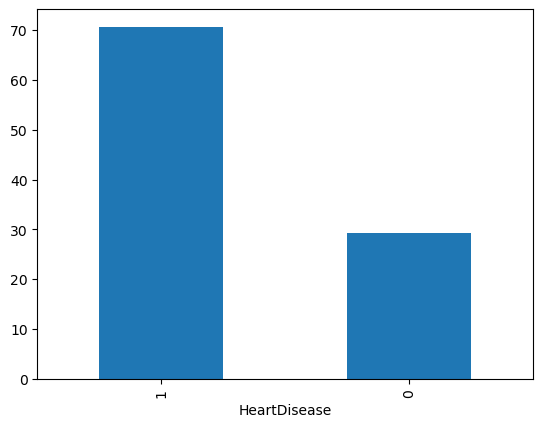

In [16]:
(heart_df[(heart_df['Sex'] == 'M') & (heart_df['Age'] > 50)]['HeartDisease'].value_counts(normalize=True) * 100).plot.bar()
plt.show()

## Data Cleaning


In the previous screen, we calculated the number of missing values in our entire dataset and didn't find any. We also plotted our categorical columns and observed a few details:

- The dataset is highly skewed towards male patients. `725` rows correspond to male patients, whereas only `193` correspond to female patients. This could potentially induce a bias in our model and impact predictions for any female patients in any unseen data.
- `410` patients were not diagnosed with heart disease, whereas `508` patients were. The target variable is somewhat evenly distributed, which is beneficial for training our model.
- A significant number of patients, `392`, diagnosed with heart disease have asymptomatic (`ASY`) chest pain. While chest pain could be a relevant feature for our model, it's should be noted that asymptomatic implies that those patients who had heart disease did not have chest pain as a symptom.
- A high number (`170`) of patients with blood sugar greater than 120 mg/dl were diagnosed with heart disease in relation to those who were not.

There are a lot of similar patterns that we can observe when we start grouping our data. These patterns can help us narrow down the features we want for training our model.

Before we move on to that, let's clean up the data. We identified that there are no missing values. However, as we noticed earlier, a couple of columns have `0` values that don't make sense.

There are a few ways we can handle these values:

- We could remove those rows entirely if their frequency of occurrence is low.
- We could impute those zeros with the median value of that column or the median value of the column grouped by HeartDisease.
- We could try some complex approaches. For example, instead of using the median of the entire column, maybe we could look at the median of the values grouped by the age, sex, and/or resting ECG of the patient. The resting blood pressure of a female in her 30s with a normal ECG might be lower than what we would get from the median of the entire column.

The third option might give us a slightly more accurate result, but given the small size of our dataset, we can ignore it for now. We'll identify how many of these values exist in our dataset and approach accordingly.

We identified that there are no missing values. However, as we noticed earlier, a couple of columns have 0 values which don't make sense.

We will look at how many zero values `RestingBP` and `Cholesterol` contain and decide how to handle those.

In [17]:
heart_df[heart_df['RestingBP'] == 0]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
449,55,M,NAP,0,0,0,Normal,155,N,1.5,Flat,1


In [18]:
heart_df[heart_df['Cholesterol'] == 0].shape[0]

172

`RestingBP` has only one zero value. We can remove that row from consideration. There are `172` zero values for `Cholesterol`. That's a relatively high number. We can't remove them all and replacing those values with the median might not be an ideal approach, but that's what we will go for now.

To be more accurate, we will replace the zero values in `Cholesterol` in relation to `HeartDisease`. So, the 0 values in `Cholesterol` for patients who were diagnosed with a heart disease will be replaced by the median of the non-zero values for patients who were diagnosed with a heart disase. And we'll do the same for those who were not diagnosed with a heart disease.

In [19]:
heart_df_clean = heart_df.copy()

# only keep non-zero values for RestingBP
heart_df_clean = heart_df_clean[heart_df_clean['RestingBP'] != 0]


In [35]:
heartdisease_mask = heart_df_clean["HeartDisease"]==0

cholesterol_without_heartdisease = heart_df_clean.loc[heartdisease_mask, "Cholesterol"]
cholesterol_with_heartdisease = heart_df_clean.loc[~heartdisease_mask, "Cholesterol"]

heart_df_clean.loc[heartdisease_mask, "Cholesterol"] = cholesterol_without_heartdisease.replace(to_replace = 0, value = cholesterol_without_heartdisease.median())
heart_df_clean.loc[~heartdisease_mask, "Cholesterol"] = cholesterol_with_heartdisease.replace(to_replace = 0, value = cholesterol_with_heartdisease.median()) 

In [36]:
heart_df_clean[['Cholesterol', 'RestingBP']].describe()

,Cholesterol,RestingBP
count,917.000000,917.000000
mean,239.700109,132.540894
std,54.352727,17.999749
min,85.000000,80.000000
25%,214.000000,120.000000
50%,225.000000,130.000000
75%,267.000000,140.000000
max,603.000000,200.000000
